In [1]:
import logging
import sys
from pathlib import Path
import itertools

import click
import numpy as np
import pandas as pd
import rasterra as rt
from rasterio.features import rasterize
from rra_tools import jobmon
import xarray as xr
import tqdm
import geopandas as gpd

from spatial_temp_cgf import paths, utils
from spatial_temp_cgf.data_prep.location_mapping import FHS_SHAPE_PATH
from spatial_temp_cgf import cli_options as clio
from spatial_temp_cgf.data import DEFAULT_ROOT, ClimateMalnutritionData

from spatial_temp_cgf.inference.run_inference import get_intercept_raster

In [4]:
output_dir = Path(DEFAULT_ROOT)
measure = 'stunting'
model_version = "2024_07_01.15"
cmip6_scenario = 'ssp126'
year = 2025

In [5]:
cm_data = ClimateMalnutritionData(output_dir / measure)
spec = cm_data.load_model_specification(model_version)
print('loading raster template and shapes')
raster_template = cm_data.load_raster_template()
fhs_shapes = cm_data.load_fhs_shapes()
print('loading models')
models = cm_data.load_model_family(model_version)

loading raster template and shapes
loading models


In [42]:
model = models[0]['model']

coefs = model.coefs['Estimate']
ranefs = model.ranef

partial_estimates = {}

for predictor in spec.predictors:
    if predictor.name == 'intercept':
        partial_estimates[predictor.name] = get_intercept_raster(
            predictor, coefs, ranefs, fhs_shapes, raster_template,
        )
    elif predictor.name == 'ldi_pc_pd':
        ldi_spec = predictor  # deal with later
    elif predictor.name == 'elevation':
        v = rt.load_raster('/mnt/team/rapidresponse/pub/population/modeling/climate_malnutrition/input/srtm_elevation.tif')
        beta = coefs.loc[predictor.name]
        partial_estimates[predictor.name] = rt.RasterArray(
            beta * np.array(model.var_info[predictor.name]['transformer'](v)),
            transform=v.transform,
            crs=v.crs,
            no_data_value=np.nan,
        )
    else:
        if predictor.random_effect:
            msg = 'Random slopes not implemented'
            raise NotImplementedError(msg)
            
        transform = predictor.transform
        variable = transform.from_column if hasattr(transform, 'from_column') else predictor.name    
        ds = cm_data.load_climate_raster(variable, cmip6_scenario, year)
        v = utils.xarray_to_raster(ds, nodata=np.nan).resample_to(raster_template)
        beta = coefs.loc[predictor.name]
        partial_estimates[predictor.name] = rt.RasterArray(
            beta * np.array(model.var_info[predictor.name]['transformer'](v)),
            transform=v.transform,
            crs=v.crs,
            no_data_value=np.nan,
        )

assert spec.extra_terms == ['any_days_over_30C * ldi_pc_pd']

beta_interaction = coefs.loc['ldi_pc_pd:any_days_over_30C'] / coefs.loc['any_days_over_30C']
beta_ldi = beta_interaction * partial_estimates['any_days_over_30C'] + coefs.loc['ldi_pc_pd']
z_partial = sum(partial_estimates.values())
    


In [43]:
prevalence = 0
for i in range(1, 11):
    print(i)
    ldi = cm_data.load_ldi(year, f"{i/10.:.1f}")
    prevalence += 0.1 * 1 / (1 + np.exp(-z_partial - beta_ldi * ldi))
    

1


/mnt/share/code/collijk/miniconda/envs/cgf/lib/python3.12/site-packages/rasterra/_array.py:240: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


2
3
4
5
6
7
8
9
10


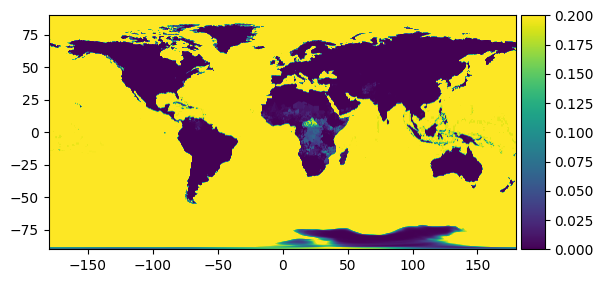

<Axes: >

In [23]:
spec.extra_terms

['any_days_over_30C * ldi_pc_pd']

In [30]:
beta_interaction

23.084732236006793